<a href="https://colab.research.google.com/github/lahlfors/DocumentAI/blob/master/Bounding_Box_DAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


This notebook shows you how to analyze a pdf using the Google Cloud DocumentAI API

In [6]:
# Install necessary Python libraries
!pip install google-cloud-documentai
!pip install wand
!pip install pillo
!apt-get update
!apt-get install poppler-utils # for converting pdf to jpg. We'll use this for displaying the pdf later
!apt-get install libmagickwand-dev

     |████████████████████████████████| 51kB 1.6MB/s 
     |████████████████████████████████| 92kB 3.3MB/s 
     |████████████████████████████████| 1.3MB 4.8MB/s 
     |████████████████████████████████| 92kB 6.7MB/s 
  Created wheel for proto-plus: filename=proto_plus-1.1.0-cp36-none-any.whl size=32919 sha256=c10829887425e30dbfc4c23af2dd40aa90603689112ae329f81c4da4ae36c75b
  Stored in directory: /root/.cache/pip/wheels/d0/c2/f9/82bd0d07a57c5a8307e6b2a121a1e7259f444a4d27b1f42b66
Successfully built proto-plus
ERROR: google-colab 1.0.0 has requirement google-auth~=1.17.2, but you'll have google-auth 1.19.0 which is incompatible.
  Found existing installation: protobuf 3.10.0
    Uninstalling protobuf-3.10.0:
      Successfully uninstalled protobuf-3.10.0
  Found existing installation: google-auth 1.17.2
    Uninstalling google-auth-1.17.2:
      Successfully uninstalled google-auth-1.17.2
  Found existing installation: google-api-core 1.16.0
    Uninstalling google-api-core-1.16.0:
      

     |████████████████████████████████| 133kB 2.7MB/s 
ERROR: Could not find a version that satisfies the requirement pillo (from versions: none)
ERROR: No matching distribution found for pillo
Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:3 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:12 http://security.ubuntu.com/ubuntu 

**Now you'll need to restart your notebook to load the new libraries before you can continue**

In [1]:
from google.cloud import documentai_v1beta2 as documentai
from wand.image import Image as WImage
from PIL import Image, ImageDraw
import os

## Set up Google Cloud Project Authentication

In [2]:
# Authenticate with Cloud
from google.colab import auth
auth.authenticate_user()

In [3]:
#@title Set Project Id
PROJECT_ID = 'my-user-project-282713'  #@param {type: "string"}
PDF_URI = "gs://cloud-samples-data/documentai/form.pdf" #@param {type: "string"}
SERVICE_ACCOUNT_NAME="laahdocai" #@param {type: "string"}

Create a service account and download keys

In [4]:
!gcloud config set project '{PROJECT_ID}'
# Uncomment the following line to create a new service account
#!gcloud iam service-accounts create {SERVICE_ACCOUNT_NAME}
!gcloud iam service-accounts keys create ./key.json --iam-account {SERVICE_ACCOUNT_NAME}@{PROJECT_ID}.iam.gserviceaccount.com
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "./key.json"

Updated property [core/project].
created key [5e20a695105942435d70e84c2f72d38bec0fa144] of type [json] as [./key.json] for [laahdocai@my-user-project-282713.iam.gserviceaccount.com]


Enable the Document AI and Invoice AI APIs

In [5]:
!gcloud services enable documentai.googleapis.com
!gcloud services enable invoice.googleapis.com

Operation "operations/acf.92c6f36e-48a5-4329-b71a-1847770332b4" finished successfully.
Operation "operations/acf.22ca69a8-1a4c-425c-a696-0162115102f2" finished successfully.


In [6]:
# Download the doc
!gsutil cp $PDF_URI ./doc.pdf

Copying gs://cloud-samples-data/documentai/form.pdf...
- [1 files][624.2 KiB/624.2 KiB]                                                
Operation completed over 1 objects/624.2 KiB.                                    


## Call the Document AI API

In [7]:
def parse_form(project_id=PROJECT_ID,
               input_uri=PDF_URI):
    """Parse a form using the Document AI API"""

    # Create a new Document AI client
    client = documentai.DocumentUnderstandingServiceClient()

    # Specify which cloud in GCS you'd like to analyze
    gcs_source = documentai.types.GcsSource(uri=input_uri)

    # mime_type can be application/pdf, image/tiff,
    # and image/gif, or application/json
    input_config = documentai.types.InputConfig(
        gcs_source=gcs_source, mime_type='application/pdf')

    # Optional: Improve form parsing results by providing 
    # key-value pair hints.
    # For each key hint, key is text that is likely to appear in the
    # document as a form field name (i.e. "DOB").
    # Value types are optional, but can be one or more of:
    # ADDRESS, LOCATION, ORGANIZATION, PERSON, PHONE_NUMBER, ID,
    # NUMBER, EMAIL, PRICE, TERMS, DATE, NAME
    key_value_pair_hints = [
        documentai.types.KeyValuePairHint(key='Emergency Contact',
                                          value_types=['NAME']),
        documentai.types.KeyValuePairHint(
            key='Referred By')
    ]

    # Setting enabled=True enables form extraction
    form_extraction_params = documentai.types.FormExtractionParams(
        enabled=True, key_value_pair_hints=key_value_pair_hints)

    # Location can be 'us' or 'eu'
    parent = 'projects/{}/locations/us'.format(project_id)
    request = documentai.types.ProcessDocumentRequest(
        parent=parent,
        input_config=input_config,
        form_extraction_params=form_extraction_params)

    document = client.process_document(request=request)
    
    return document


In [8]:
doc = parse_form(PROJECT_ID)

Let's check out the response

In [9]:
# This document consists of one page
len(doc.pages)

1

In [10]:
# It's got 17 form fields
len(doc.pages[0].form_fields)

17

In [11]:
# This is what a form field looks like
doc.pages[0].form_fields[0]

field_name {
  text_anchor {
    text_segments {
      start_index: 325
      end_index: 327
    }
  }
  confidence: 0.9999823570251465
  bounding_poly {
    normalized_vertices {
      x: 0.5433105230331421
      y: 0.25519150495529175
    }
    normalized_vertices {
      x: 0.6368563771247864
      y: 0.25519150495529175
    }
    normalized_vertices {
      x: 0.6368563771247864
      y: 0.2925703823566437
    }
    normalized_vertices {
      x: 0.5433105230331421
      y: 0.2925703823566437
    }
  }
  orientation: 1
}
field_value {
  text_anchor {
    text_segments {
      start_index: 327
      end_index: 343
    }
  }
  confidence: 0.9999823570251465
  bounding_poly {
    normalized_vertices {
      x: 0.6395664215087891
      y: 0.25380709767341614
    }
    normalized_vertices {
      x: 0.8802167773246765
      y: 0.25380709767341614
    }
    normalized_vertices {
      x: 0.8802167773246765
      y: 0.2925703823566437
    }
    normalized_vertices {
      x: 0.63956642150

## Helper Function for Parsing API Response

In [12]:
def get_text(document, el):
    """Doc AI identifies form fields by their offsets
    in document text. This function converts offsets
    to text snippets.
    
     Parameters:
    doc (documentai.proto): Proto returned from docai api
    el (documentai.entity): Single entity from the doc

    Returns:
    array of {"x": float, "y": float} bounding box of the entity
    """
    response = ''
    # If a text segment spans several lines, it will
    # be stored in different text segments.
    for segment in el.text_anchor.text_segments:
        start_index = segment.start_index
        end_index = segment.end_index
        response += document.text[start_index:end_index]
    return response

In [13]:
# Form fields are given as character offsets in text:
#  text_anchor {
#     text_segments {
#       start_index: 325
#       end_index: 327
#     }
#   }
# To convert text offsets to actual words, we'll use the helper function get_text

for form_field in doc.pages[0].form_fields:
  field_name = get_text(doc, form_field.field_name).strip()
  field_value = get_text(doc, form_field.field_value).strip()
  print(f"{field_name}\t{field_value}")

#:	_(906) 917-3486
Emergency Contact:	Eva Walker
Marital Status:	Single
Gender:	_F
Occupation:	Software Engineer
Referred By:	None
Date:	9/14/19
DOB:	09/04/1986
Address:	24 Barney Lane
City:	Tonaco
Name:	Sally Walker
State:	NJ
Email:	Sally, waller@cmail.com_Phone
Zip:	07082
Emergency Contact Phone:	(906)334-89766
Are you currently taking any medication? (If yes, please describe)	you currently taking any medication? (If yes, please describe):
Vyvanse (25mg) daily for attention
Describe your medical concerns (symptoms, diagnoses, etc):	Ranny nose, mucas in thoat, weakness,
aches, chills, tired


## Download the file and convert it to a jpg
This way, we can draw on it here in this Jupyter Notebook

In [14]:
!pdfimages -j doc.pdf doc

## Print the Entities and Draw the Boxes!

In [15]:
im = Image.open('doc-000.jpg')
draw = ImageDraw.Draw(im)
for form_field in doc.pages[0].form_fields:
    # Draw the bounding box around the form_fields
    # Forst get the co-ords of the field name
    vertices = []
    for vertex in form_field.field_name.bounding_poly.normalized_vertices:
      vertices.append({'x': vertex.x * im.size[0], 'y': vertex.y * im.size[1]})
    draw.polygon([
        vertices[0]['x'], vertices[0]['y'],
        vertices[1]['x'], vertices[1]['y'],
        vertices[2]['x'], vertices[2]['y'],
        vertices[3]['x'], vertices[3]['y']], outline='red')
    
    vertices = []
    for vertex in form_field.field_value.bounding_poly.normalized_vertices:
        vertices.append({'x': vertex.x * im.size[0], 'y': vertex.y * im.size[1]})
    draw.polygon([
        vertices[0]['x'], vertices[0]['y'],
        vertices[1]['x'], vertices[1]['y'],
        vertices[2]['x'], vertices[2]['y'],
        vertices[3]['x'], vertices[3]['y']], outline='blue')

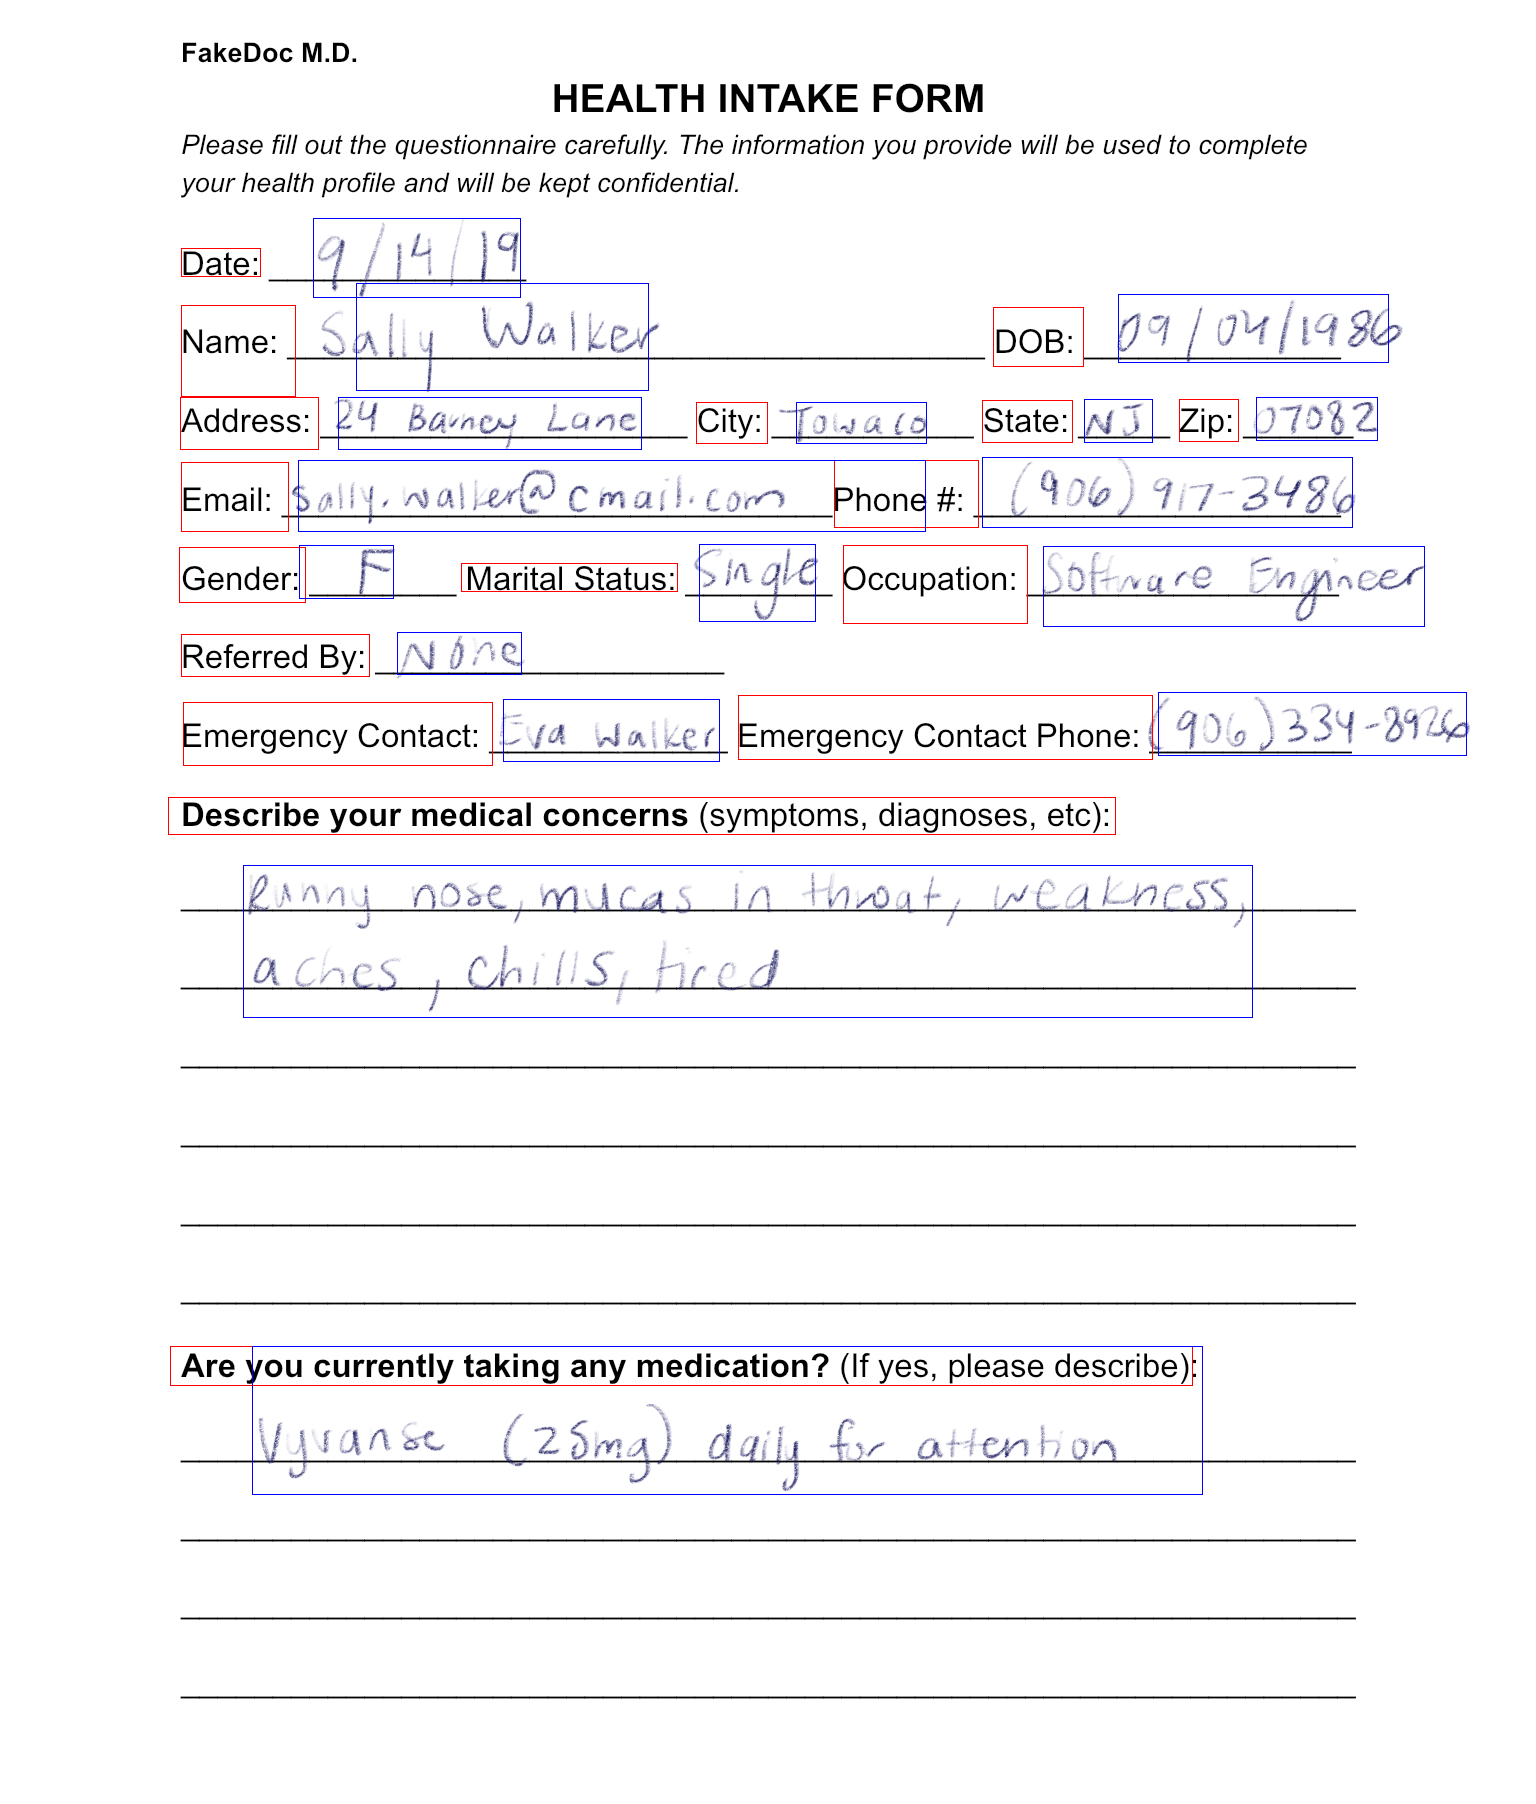

In [16]:
im